In [1]:
from pdpbox import pdp
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd


## Preprocessing

In [2]:
raw_data = pd.read_csv("../../data_clean.csv")
data = raw_data[raw_data['birth date'] < 2020].copy()

data['age'] = data['parole board interview date'] - data['birth date']
data['jail duration'] = data['parole board interview date'] - data['year of entry']

others_parole_type =  ['PIE', 'SP CONSDR', 'ECPDO', 'MEDICAL','RESCISSION', 'DEPORT']
data['parole board interview type'] = data['parole board interview type'].replace(others_parole_type, 'OTHERS').replace('SUPP MERIT', 'MERIT TIME').replace('PV REAPP', 'REAPPEAR')

data = data.dropna(axis=0, subset=['crime 1 - class', 'parole eligibility date'])

df_one_hot = pd.get_dummies(data, columns=[
    "sex", "race / ethnicity"], drop_first=True)

df_one_hot = pd.get_dummies(df_one_hot, columns=[
    "crime 1 - class", "crime 2 - class",
    "crime 3 - class", "crime 4 - class",
    "parole board interview type"])

df_one_hot.drop(columns=['release date','birth date', 'year of entry'],inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df_one_hot.drop('y',axis=1), df_one_hot['y'], 
                                                    stratify=df_one_hot['y'], test_size=0.3, random_state=42)

## Loading the model

In [3]:
# Load the model from the .pkl file
xgb_classifier = pickle.load(open("../model.pkl", "rb"))


## PDP

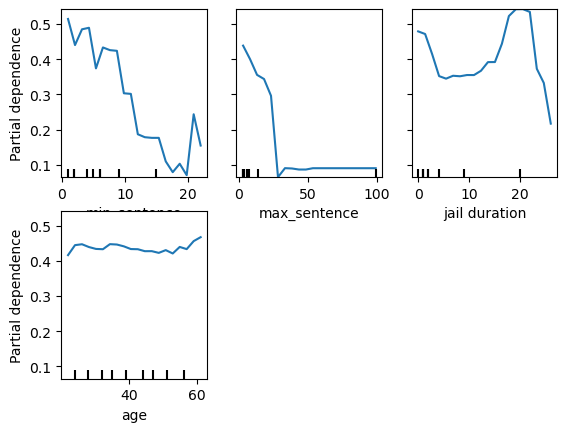

In [4]:
import pandas as pd
import pickle
from sklearn.inspection import PartialDependenceDisplay

# Load the model from the .pkl file
xgb_classifier = pickle.load(open("../model.pkl", "rb"))

# Assuming X_train is your features dataset
features = ['min_sentence', 'max_sentence', 'jail duration', 'age']
feature_names = list(X_train.columns)
# Use PartialDependenceDisplay.from_estimator to create the PDPs
PartialDependenceDisplay.from_estimator(
    xgb_classifier, X_train, features=features,
    feature_names=feature_names,  # Replace with the actual feature names
    grid_resolution=20  # Controls the number of values to plot on the x-axis
)

# To show the plot if not using an interactive environment like Jupyter Notebook
import matplotlib.pyplot as plt
plt.show()


## ALE

In [5]:
from codecarbon import EmissionsTracker
tracker = EmissionsTracker()
tracker.start()

from PyALE import ale

features = ['min_sentence', 'max_sentence', 'jail duration', 'age']
X_sample = X_train[:1000]
for feature in features :
    ale_contin = ale(
        X=X_train,
        model=xgb_classifier,
        feature=[feature],
        feature_type="continuous",
        grid_size=20,
        include_CI=True,
        C=0.95,
    )
    
emissions: float = tracker.stop()
print(emissions)


[codecarbon INFO @ 14:51:56] [setup] RAM Tracking...
[codecarbon INFO @ 14:51:56] [setup] GPU Tracking...
[codecarbon INFO @ 14:51:56] Tracking Nvidia GPU via pynvml


NVMLError_NotSupported: Not Supported

## ICE

In [6]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence

# Load the model from the .pkl file
xgb_classifier = pickle.load(open("../model.pkl", "rb"))

# Assuming X_train is your features dataset
features = ['min_sentence', 'max_sentence', 'jail duration', 'age']
feature_names = list(X_train.columns)

# Plot the centered ICE plots
for feature in features:
    # Calculate the partial dependence values
    pdp_result = partial_dependence(xgb_classifier, X_train.sample(n=500,random_state=42), [feature], kind="both")
    
    # Get the individual and average values
    individual_pd = pdp_result.individual[0]
    average_pd = pdp_result.average[0]
    values = pdp_result.grid_values[0]  # Updated from 'values' to 'grid_values'
    
    # Find the index of the minimum feature value to use as a reference
    reference_index = np.argmin(values)
    
    # Centering the ICE data by subtracting the value of each line at the reference index
    individual_centered = individual_pd - individual_pd[:, reference_index, np.newaxis]
    
    plt.figure()
    for ice_line in individual_centered:
        plt.plot(values, ice_line, color='red', alpha=0.1)
    
    # Center the average partial dependence as well
    average_centered = average_pd - average_pd[reference_index]
    
    plt.plot(values, average_centered, color='blue', label='Average PD')
    
    plt.title(f"Centered ICE plot for {feature}")
    plt.xlabel(feature)
    plt.ylabel('Partial dependence adjusted to start at 0')
    plt.legend()
    plt.show()


AttributeError: grid_values

## SHAP

In [7]:
import shap
# Load JS visualization code to notebook
shap.initjs()
# Create a SHAP explainer object
explainer = shap.TreeExplainer(xgb_classifier)
# Calculate SHAP values - this may take some time depending on the size of your dataset and model complexity
X_train_summary = shap.sample(X_train, 100)  # Use a subset of data as a representative for training data
shap_values = explainer.shap_values(X_train_summary)
# Define column grouping for aggregation
columns_to_group = {
    'race / ethnicity': ['race / ethnicity_ASIAN/PACIFIC', 'race / ethnicity_BLACK', 'race / ethnicity_HISPANIC',
                         'race / ethnicity_OTHER', 'race / ethnicity_UNKNOWN', 'race / ethnicity_WHITE'],
    'crime 1 - class': ['crime 1 - class_A', 'crime 1 - class_B', 'crime 1 - class_C', 'crime 1 - class_D', 'crime 1 - class_E'],
    'crime 2 - class': ['crime 2 - class_A', 'crime 2 - class_B', 'crime 2 - class_C', 'crime 2 - class_D', 'crime 2 - class_E'],
    'crime 3 - class': ['crime 3 - class_A', 'crime 3 - class_B', 'crime 3 - class_C', 'crime 3 - class_D', 'crime 3 - class_E'],
    'crime 4 - class': ['crime 4 - class_A', 'crime 4 - class_B', 'crime 4 - class_C', 'crime 4 - class_D', 'crime 4 - class_E'],
    'parole board interview type': ['parole board interview type_INITIAL', 'parole board interview type_MERIT TIME',
                                   'parole board interview type_OTHERS', 'parole board interview type_REAPPEAR']
}
# Aggregate SHAP values for each column group
aggregated_shapley_values = np.zeros((shap_values.shape[0], len(columns_to_group)))
for group_index, (group_name, group_columns) in enumerate(columns_to_group.items()):
    group_indices = [list(X_train_summary).index(column) for column in group_columns]
    group_shapley_values = shap_values[:, group_indices]
    aggregated_shapley_values[:, group_index] = np.sum(group_shapley_values, axis=1)
final_shap_values = np.concatenate([shap_values[:,:8], aggregated_shapley_values, ], axis=1)
concat_X_train_summary = X_train_summary.copy()
#Race
concat_X_train_summary["race"] = X_train_summary[['race / ethnicity_ASIAN/PACIFIC',
       'race / ethnicity_BLACK', 'race / ethnicity_HISPANIC',
       'race / ethnicity_OTHER', 'race / ethnicity_UNKNOWN',
       'race / ethnicity_WHITE']].idxmax(1)
concat_X_train_summary.drop(columns=['race / ethnicity_ASIAN/PACIFIC',
       'race / ethnicity_BLACK', 'race / ethnicity_HISPANIC',
       'race / ethnicity_OTHER', 'race / ethnicity_UNKNOWN',
       'race / ethnicity_WHITE'], inplace=True)
#Crime1
concat_X_train_summary["crime1"] = X_train_summary[['crime 1 - class_A', 'crime 1 - class_B',
       'crime 1 - class_C', 'crime 1 - class_D', 'crime 1 - class_E']].idxmax(1)
concat_X_train_summary.drop(columns=['crime 1 - class_A', 'crime 1 - class_B',
       'crime 1 - class_C', 'crime 1 - class_D', 'crime 1 - class_E'], inplace=True)
#Crime2
concat_X_train_summary["crime2"] = X_train_summary[['crime 2 - class_A', 'crime 2 - class_B', 'crime 2 - class_C',
       'crime 2 - class_D', 'crime 2 - class_E']].idxmax(1)
concat_X_train_summary.drop(columns=['crime 2 - class_A', 'crime 2 - class_B', 'crime 2 - class_C',
       'crime 2 - class_D', 'crime 2 - class_E'], inplace=True)
#Crime1
concat_X_train_summary["crime3"] = X_train_summary[['crime 3 - class_A', 'crime 3 - class_B',
       'crime 3 - class_C', 'crime 3 - class_D', 'crime 3 - class_E']].idxmax(1)
concat_X_train_summary.drop(columns=['crime 3 - class_A', 'crime 3 - class_B',
       'crime 3 - class_C', 'crime 3 - class_D', 'crime 3 - class_E'], inplace=True)
#Crime2
concat_X_train_summary["crime4"] = X_train_summary[['crime 4 - class_A', 'crime 4 - class_B', 'crime 4 - class_C',
       'crime 4 - class_D', 'crime 4 - class_E']].idxmax(1)
concat_X_train_summary.drop(columns=['crime 4 - class_A', 'crime 4 - class_B', 'crime 4 - class_C',
       'crime 4 - class_D', 'crime 4 - class_E'], inplace=True)
#Parole board interview type
concat_X_train_summary["Parole board interview type"] = X_train_summary[['parole board interview type_INITIAL',
       'parole board interview type_MERIT TIME',
       'parole board interview type_OTHERS',
       'parole board interview type_REAPPEAR']].idxmax(1)
concat_X_train_summary.drop(columns=['parole board interview type_INITIAL',
       'parole board interview type_MERIT TIME',
       'parole board interview type_OTHERS',
       'parole board interview type_REAPPEAR'], inplace=True)
# Visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, final_shap_values[1,:], concat_X_train_summary.iloc[1,:])
# Summarize the effects of all the features
#shap.summary_plot(final_shap_values, concat_X_train_summary)